# Neural Networks

**Deep Learning**

Joaquin Vanschoren, Eindhoven University of Technology

In [1]:
# Global imports and settings
from preamble import *
import tensorflow as tf
print("Using Keras",tf.keras.__version__)
%matplotlib inline
%matplotlib widget
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

Using Keras 2.2.4-tf


## Overview
* Mathematical foundations
    * Tensors and tensor operations
    * Backpropagation and gradient descent
* Evaluation and Regularization
* Text Representations

### Neural networks
* The core building block of a neural network is the _layer_
* You can think of it as a _filter_ for the data
    - Data goes in, and comes out in a more useful form
* Layers extract new _representations_ of the data
* _Deep learning_ models contain many such layers
    - They progressively _distill_ (refine) the data
<img src="../images/00_layers.png" alt="ml" style="width: 500px;"/>

#### Feature maps
- Each layer transforms (maps) an input to possibly multiple outputs
- Each layer needs to _learn_ how to do the mapping so that the final output is correct
- There are different _types_ of layers that are constrained to certain mappings
    - Allows us to introduce mappings which we think are useful: *flexible!*
<img src="../images/00_layers2.png" alt="ml" style="width: 60%"/>

#### Terminology

1. Numerical(!) input features are fed to individual _nodes_ of the _input layer_ (yellow)
2. Each input is passed to a set of nodes in the _hidden layers_ (blue)
    - In _dense_ layers, every previous layer node is connected to all nodes
    - Every node produces an output that is some function of all its inputs
3. The _output layer_ has a node for every possible outcome (red)
    - A single regression value, multiple possible classes, or entire output images/signals/...  
<img src="../images/08_nn_manylayers.png" alt="ml" style="width: 500px;"/>

#### Nodes
* Each node gives each of its inputs a weight $w_i$ 
* Each node also has a bias $b$
    * Sometimes 'drawn' as an extra input with value '1'
* In its simplest form (a.k.a. the perceptron), each node outputs a weighted sum of the inputs: $y = \sum_{i} x_{i}w_i + b$
    * This is indeed equivalent to a linear model 
* Even a deep neural net of perceptrons can only learn a linear model
    * To learn a non-linear model we need to transform $y$ with an _activation function_ $f$

<img src="../images/perceptron.png" alt="ml" style="width: 500px;"/>


#### Activation functions
* For hidden nodes, popular choices are the _rectified linear unit_ (ReLU) and _tanh_
    - There are many others. We'll come back to this soon!
    - ReLU is very cheap to compute, speeds up training
* For classification, we use _softmax_ (or sigmoid)
    - Transforms the input into a probability for each specific class
    - This is exactly what we used for logistic regression!
<img src="../images/08_activation.png" alt="ml" style="width: 1000px;"/>

#### Training Neural Nets
* Each layer starts with random (small) weights
    - Or weights could be _transferred_ from previously trained models (transfer learning or meta-learning)
* _Loss function_: Measures how well the model fits the training data
* _Optimizer_: Defines how to update the weights, e.g. gradient descent

<img src="../images/09_overview.png" alt="ml" style="width: 400px;"/>

#### Representing data
* We can represent all layer inputs (and outputs) as _tensors_
    * These are numerical n-dimensional array (with n axes)
    * 2D tensor: matrix (samples, features)
    * 3D tensor: grayscale images (samples, height, width)
        - or time series (samples, timesteps, features)
    * 4D tensor: color images (samples, height, width, channels)
    * 5D tensor: video (amples, frames, height, width, channels)  
    
<img src="../images/08_timeseries.png" alt="ml" style="float: left; width: 30%;"/>
<img src="../images/08_images.png" alt="ml" style="float: left; width: 30%;"/>

#### Implementing layers (from scratch)
* The operations that neural network layers perform on the data can be reduced to a _series of tensor operations_
* Imagine that we have a 2D input tensor $\mathbf{x}$
* A dense layer with ReLU activation could be implemented as:

``` python
y = relu(dot(W, x) + b)
```
* Uses a 2D weight tensor $\mathbf{W}$
    * One weight for every combination of input $x_i$ and node $n_j$
* and a bias vector $\mathbf{b}$ (one value per node $n_j$)
* Performs a dot product, addition, and $relu(x) = max(x,0)$

#### Element-wise operations

ReLU and addition are element-wise operations. Since numpy arrays support element-wise operations natively, these are simply:

``` python
def relu(x):
  return np.maximum(x, 0.)

def add(x, y):
  return x + y
```

Note: if y has a lower dimension than x, it will be _broadcasted_: axes are added to match the dimensionality, and y is repeated along the new axes 

``` python
>>> np.array([[1,2],[3,4]]) + np.array([10,20])
array([[11, 22],
       [13, 24]])
```

#### Tensor dot
The dot product $x . y$ of two tensors can also be done easily with numpy:
``` python 
z = np.dot(x, y)
# z[i,j] = x[i,:] * y[:,j]
```
E.g. input $\mathbf{x}$ has $a$ samples of $b$ features, and $\mathbf{y}$ is the 
weight tensor for a dense layer with $c$ nodes, then $z$ is the layer output (with $c$ features)

<img src="../images/08_dot.png" alt="ml" style="width: 400px;"/>



#### Geometric interpretation
* Dot product $z_{i,j} = x_i . w_j$ projects every vector $x_i$ (colored) onto weight vector $w_j$ (gray)
* $z_{i,j}$ is the projection length (colored line segment, until origin)
* In short, the dot product changes how the (colored) points relate to each other 
* We aim to find a transformation $\mathbf{W}$ of $x$ so that it becomes easy to:
    - separate the classes (classification)
    - learn a simple function (regression)

<img src="../images/dot_product2.png" alt="ml" style="width: 400px;"/>

### Gradient-based optimization
* How to find good values for $W$ and $b$ so that the data is transformed to a useful representation?
* Start with a random initialization (small random weights)
    - _Symmetry breaking_: create sufficient variation in output features
* Then loop:
    1. Draw a batch of training data $x$
    2. _Forward pass_: run the network on $x$ to yield $y_{pred}$ (tensor operations)
    3. Compute the loss (mismatch between  $y_{pred}$ and $y$)
    4. Update $W$, $b$ in a way that slightly reduces the loss (OK, but how?)

#### Update rule
Naive approach (expensive):
* Choose one weight $w_{i,j}$ to optimize, freeze the others
* Run the network (twice) with $w_{i,j} - \epsilon$ and $w_{i,j} + \epsilon$
* Compute the losses $L(x,w_{i,j} - \epsilon)$ and $L(x,w_{i,j} + \epsilon)$ given current batch x
* Keep the one that reduces the loss most, then repeat

<img src="../images/08_gradient.png" alt="ml" style="float: right; width: 30%;"/>

Better:
* Choose a loss function L that is _differentiable_
    * Also all underlying tensor operations need to be differentiable
* Then we can compute the derivative $\frac{\partial L(x,w_{i,j})}{\partial w_{i,j}} = a$
* So that $L(x,w_{i,j} + \epsilon) \approx y + a * \epsilon$
* We can now estimate weights without recomputing $L$

#### Gradients
* A _gradient_ $\nabla L$ is the generalization of a derivate to n-dimensional inputs
    * Approximates the _curvature_ of the loss function $L(x,W)$ around a given point $W$
    * Vector of partial derivatives $\nabla L = \left[ \frac{\partial L}{\partial w_{0,0}}, \frac{\partial L}{\partial w_{0,1}},... \right]$
* Update: if $L$ is differentiable, then _new_ weight tensor $W_{i+1}$ = $W_i$ - $\frac{\partial L(W_i)}{\partial W} * step$ 
    * _step_ is a small scaling factor (learning rate)
    * Go against the curvature to a lower place on the curve
* Now repeat with a new batch of data $x$

<img src="../images/08_2dgradient_derive.gif" alt="ml" style="float: left; width: 30%;"/>
<img src="../images/08_2dgradient_update.png" alt="ml" style="float: left; width: 40%;"/>


#### Stochastic gradient descent (SGD)
Mini-batch SGD:
1. Draw a batch of *batch_size* training data $x$ and $y$
2. _Forward pass_: run the network on $x$ to yield $y_{pred}$ (tensor operations)
3. Compute the loss L (mismatch between  $y_{pred}$ and $y$)
4. _Backward pass_: Compute the gradient of the loss with regard to $W$
5. Update W: $W_{i+1} = W_i - \frac{\partial L(x, W_i)}{\partial W} * step$

Repeat until n passes (epochs) are made through through the entire training set.

SGD Variants:
* Batch Gradient Descent: compute gradient on entire training set
    - More accurate gradients, but more expensive
* True Stochastic Gradient Descent: repeat for each individual data points (noisy)
* Minibatch SGD strikes a balance between the two (given the right batch size)
    
<img src="../images/08_sgd1d.png" alt="ml" style="float: left; width: 25%;"/>
<img src="../images/08_SGD.png" alt="ml" style="float: left; width: 400px;"/>

#### SGD: many more variants
* With SGD, it is quite easy to get stuck in a local minimum
* Learning rate decay: start with a big step size and then decrease
* Momentum: do a larger update if previous update has large loss improvement
    - Like a ball that gains speed if it goes down steeply
* Adaptive step size for each $W_i$: adam, Adagrad,...
    - See http://ruder.io/optimizing-gradient-descent/index.html
* Some intuitions say that in high-dimensional spaces, most local minima are near the global minimum

<img src="../images/08_sgdvars.png" alt="ml" style="float: left; width: 300px;"/>

#### Backpropagation
* In practice, a neural network function consist of many tensor operations chained together
    - e.g. $f(W1, W2, W3) = a(W1, b(W2, c(W3)))$
* How can we still compute $\frac{\partial L(x, W)}{\partial W}$?
* As long as each tensor operation is differentiable, we can still compute the gradient thanks to the chain rule:
    $$f(g(x)) = f'(g(x)) * g'(x)$$
* We can let the gradient _backpropagate_ through the layers
* So, if we have a hidden node $h(x)=f(W_1 x+b_1)$, $net(x) = W_1 x+b_1$, and output node $o(x)=g(W_2 h(x)+b_2)$

<img src="../images/08_chainrule2.png" alt="ml" style="width: 600px;"/>

### Intuition
- Imagine a demon that adds a change $\Delta x_j = {x_{j,0}, x_{j,1}, ...}$ to inputs of neuron $j$
    - The neuron now outputs $\sigma(x_j + \Delta x_j)$ instead of $\sigma(x_j)$
    - Propagates through network, ultimately causing an error $\frac{\delta E}{\delta x_j} \Delta x_j$
- A _good_ demon tries to find a $\Delta x_j$ that _reduces_ the error
    - If it knows $\frac{\delta E}{\delta x_j}$ is large, it chooses $\Delta x_j$ to reduce it
    - If gradient $\frac{\delta E}{\delta x_j} > 0$, increasing the output of $x_j$ will increase the error
    - Decrease the output by increasing the weights of negative inputs, or decreasing the weights of positive inputs.

![Tampering with the weights creates an error downstream.](./images/07_demon.png)

### Backpropagation in action
To get an intuitive understanding of how backpropagation works, here is a nice animation of the entire process:
    https://youtu.be/Ilg3gGewQ5U?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&t=403

## Using neural networks
Example: Fashion-MNIST dataset contains 28x28 pixel images of 10 classes of fashion items

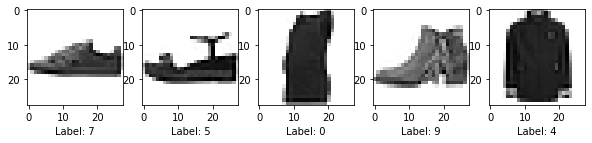

In [2]:
# Download FMINST data. Takes a while the first time.
mnist = oml.datasets.get_dataset(40996)
X, y, _, _ = mnist.get_data(target=mnist.default_target_attribute, dataset_format='array');
X = X.reshape(70000, 28, 28)

# Take some random examples
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,70000)
    axes[i].imshow(X[n], cmap=plt.cm.gray_r)
    axes[i].set_xlabel("Label: {}".format(y[n]))
plt.show();

In [3]:
from sklearn.model_selection import train_test_split
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X, y, train_size=60000)

### Building the network
* One dense hidden ReLU layer with 128 nodes
    - Input from a 28x28 matrix
* Output softmax layer with 10 nodes
* Example using Keras, a well-known API for building neural networks
    * Integrated in Tensorflow, but also in other backends

``` python
from tensorflow.keras import models
from tensorflow.keras import layers

network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))
```

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers

network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

Model summary
- Lots of parameters (weights and biases) to learn!
    - hidden layer: (28 * 28 + 1) * 128 = 100480
    - output layer: (128 + 1) * 10

In [5]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### Compilation
We still need to specify how we want the network to be trained:
* __Loss function__: The objective function used to measure how well the model is doing, and steer itself in the right direction
    - e.g. Cross Entropy (_negative log likelihood_ or _log loss_) for classification
* __Optimizer__: How to optimize the model weights in every iteration.
    - usually a [variant of stochastic gradient descent](http://ruder.io/optimizing-gradient-descent/index.html#momentum)
    - `RMSprop` uses different learning rates for every weight
* __Metrics__ to monitor performance during training and testing.
    - e.g. accuracy
    
``` python
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
```

In [6]:
network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

#### Cross-entropy loss
* We've seen _cross-entropy loss_ (or _log loss_) over $C$ classes before
    - Measures how similar the actual and predicted probability distributions are
    - Compute cross-entropy $H(y,\hat{y})$ between true $y$ and predicted $\hat{y}$
        $$ H(y,\hat{y}) = - \sum_{c=1}^C y_c \log(\hat{y}_c)$$
    - Sum up over all training samples
* _binary cross-entropy loss_ is the case for 2 classes ($i=0,1$ $y_1=y$, $y_0=1-y$, $y_1=\hat{y}$, $y_0=1-\hat{y}$)
$$ H(y,\hat{y}) = - y log(\hat{y}) - (1-y) log(1-\hat{y})$$

Cross-entropy loss
* exponentially larger penalty as the predicted probability $\hat{y}$ is further away from the ground truth 
(here: $y = 1$)

<img src="../images/09_cross-entropy.png" alt="ml" style="width: 600px;"/>

#### Preprocessing 
* Neural networks are sensitive to scaling, so always scale the inputs
* The network expects the data in a certain shape, e.g. (n, 28 * 28)
    - reshape the tensor to the correct input shape
* In classification, every class is an output node, so categorically encode the labels
    - e.g. class '4' becomes [0,0,0,0,1,0,0,0,0,0]

In [7]:
Xf_train = Xf_train.reshape((60000, 28 * 28))
Xf_test = Xf_test.reshape((10000, 28 * 28))

Xf_train = Xf_train.astype('float32') / 255
Xf_test = Xf_test.astype('float32') / 255

from tensorflow.keras.utils import to_categorical
yf_train = to_categorical(yf_train)
yf_test = to_categorical(yf_test)

#### Training
* Optimizes the model parameters (weights) with mini-batch SGD
* We choose 5 epochs and a batch size of 128

In [8]:
network.fit(Xf_train, yf_train, epochs=5, batch_size=32);

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 99us/sample - loss: 0.5078 - accuracy: 0.8192
Epoch 2/5
60000/60000 [==============================] - 6s 96us/sample - loss: 0.3829 - accuracy: 0.8632
Epoch 3/5
60000/60000 [==============================] - 5s 84us/sample - loss: 0.3516 - accuracy: 0.8753
Epoch 4/5
60000/60000 [==============================] - 6s 102us/sample - loss: 0.3341 - accuracy: 0.8824
Epoch 5/5
60000/60000 [==============================] - 6s 98us/sample - loss: 0.3223 - accuracy: 0.8868


#### Prediction
We can now call `predict` or `predict_proba` to generate predictions

``` python
network.predict(X_test)
```

Prediction:  [0.994607  0.        0.0000003 0.0000022 0.        0.        0.0053905
 0.        0.        0.       ]


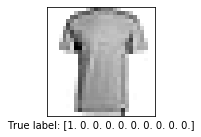

In [9]:
np.set_printoptions(precision=7)
fig, axes = plt.subplots(1, 1, figsize=(2, 2))
axes.imshow(Xf_test[1].reshape(28, 28), cmap=plt.cm.gray_r)
axes.set_xlabel("True label: {}".format(yf_test[1]))
axes.set_xticks([])
axes.set_yticks([])
print("Prediction: ",network.predict(Xf_test)[1])

#### Evaluation
Evaluate the trained model on the entire test set

``` python
test_loss, test_acc = network.evaluate(X_test, y_test)
```

In [10]:
test_loss, test_acc = network.evaluate(Xf_test, yf_test)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 58us/sample - loss: 0.3382 - accuracy: 0.8824
Test accuracy: 0.8824


#### Tuning the model
* There are a *lot* of choices that can (should) be optimized:
    - Number and types of layers
    - Layer hyperparameters
        - Number of nodes, shape
        - Activation functions
        - ...
    - Loss function (and hyperparameters)
    - SGD optimizer (and hyperparameters)
        - Learning rate
        - Batch size
        - Number of epochs
        - ...

#### Tuning the number of epochs
* How many epochs do we need for training?
* Train the neural net and track the loss after every iteration on a validation set
* We start with 20 epochs in minibatches of 512 samples

In [11]:
# Using IMDB dataset for now (much faster)
# TODO: replace with sample of FMINST?
from tensorflow.keras.datasets import imdb
# Download IMDB data with 10000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# Convert 0/1 labels to float
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [12]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                        epochs=20, batch_size=512, verbose=0,
                        validation_data=(x_val, y_val))

We can now retrieve visualize the loss on the validation data
* The training loss keeps decreasing, due to gradient descent
* The validation loss peaks after a few epochs, after which the model starts to overfit

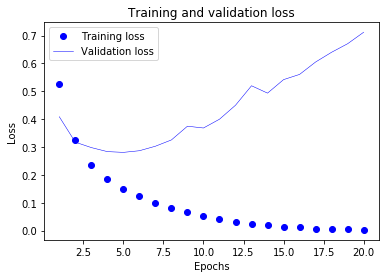

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Confirm that accuracy follows the same (although inverse) behavior as the loss

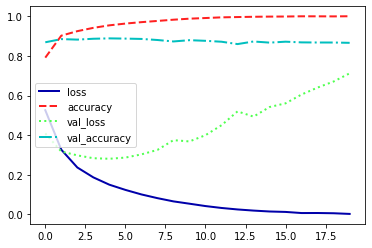

In [14]:
# Alternative plotting code
pd.DataFrame(history.history).plot(lw=2);

#### Early stopping
One simple technique to avoid overfitting is to use the validation set to 'tune' the optimal number of epochs
* In this case, we could stop after 4 epochs
* Note: validation loss can be bumpy, best use a moving average of inspect manually. 

``` python
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=0)
result = model.evaluate(x_test, y_test)
```

In [15]:
model.fit(x_train, y_train, epochs=4, batch_size=512, verbose=0)
result = model.evaluate(x_test, y_test)
print("Loss: {:.4f}, Accuracy:  {:.4f}".format(*result))

25000/25000 [==============================] - 4s 157us/sample - loss: 0.4960 - accuracy: 0.8604
Loss: 0.4960, Accuracy:  0.8604


### Regularization: build smaller networks
* The easiest way to avoid overfitting is to use a simpler model
* The number of learnable parameters is called the model _capacity_
* A model with more parameters has a higher _memorization capacity_
    - The entire training set can be `stored` in the weights
    - Learns the mapping from training examples to outputs
* Forcing the model to be small forces it to learn a compressed representation that generalizes better
    - Always a trade-off between too much and too little capacity
* Start with few layers and parameters, incease until you see diminisching returns

#### Tuning the number of nodes
* If a layer is too 'narrow', it will 'drop' some information, which can never be recovered by subsequent layers
    *  _Information bottleneck_: information-theoretic framework to compute a bound on the `capacity` of the network
* Imagine that you need to learn 10 outputs (e.g. classes) and your hidden layer has 2 nodes
    * This is like trying to learn 10 separating hyperplanes from a 2-dimensional representation
* If your layers are too 'wide', the network will overfit, basically 'memorizing' the training data
    * Try to make the layers as small as possible (e.g. using the validation set), but not smaller 

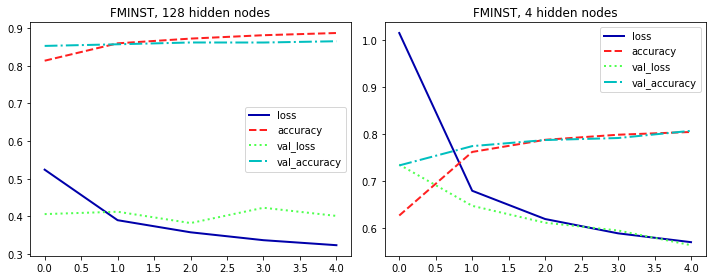

In [16]:
network = models.Sequential()
network.add(layers.Dense(128, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

xf_val, partial_xf_train = Xf_train[:10000], Xf_train[10000:]
yf_val, partial_yf_train = yf_train[:10000], yf_train[10000:] 

network.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = network.fit(partial_xf_train, partial_yf_train,
                    epochs=5, batch_size=32, verbose=0,
                    validation_data=(xf_val, yf_val))

network2 = models.Sequential()
network2.add(layers.Dense(4, activation='relu', input_shape=(28 * 28,)))
network2.add(layers.Dense(10, activation='softmax'))

network2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])
history2 = network2.fit(partial_xf_train, partial_yf_train,
                      epochs=5, batch_size=32, verbose=0,
                      validation_data=(xf_val, yf_val))

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
pd.DataFrame(history.history).plot(lw=2, ax=ax1)
pd.DataFrame(history2.history).plot(lw=2, ax=ax2)
ax1.set_title("FMINST, 128 hidden nodes")
ax2.set_title("FMINST, 4 hidden nodes")
plt.tight_layout();

#### Weight regularization
* As we did many times before, we can also add weight regularization to our loss function
- L1 regularization: leads to _sparse networks_ with many weights that are 0
- L2 regularization: leads to many very small weights
    - Also called _weight decay_ in neural net literature
* In Keras, add `kernel_regularizer` to every layer

``` python
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))
```

In [17]:
from tensorflow.keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [18]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [19]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512, verbose=0,
                             validation_data=(x_test, y_test))

In [20]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_hist = model.fit(x_train, y_train,
                         epochs=20,
                         batch_size=512, verbose=0,
                         validation_data=(x_test, y_test))

L2 regularized model is much more resistant to overfitting, even though both have the same number of parameters

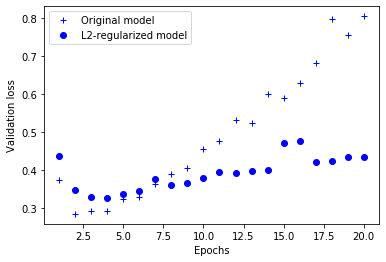

In [21]:
l2_model_val_loss = l2_model_hist.history['val_loss']
original_val_loss = model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

You can also try L1 loss or both at the same time
``` python
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)
```

### Dropout
* One of the most effective and commonly used regularization techniques
* Randomly set a number of outputs of the layer to 0 every iteration
* Idea: break up accidental non-significant learned patterns 
* _Dropout rate_: fraction of the outputs that are zeroed-out
    - Usually between 0.2 and 0.5
* At test time, nothing is dropped out, but the output values are scaled down by the dropout rate
    - Balances out that more units are active than during training
* In Keras: add `Dropout` layers between the normal layers

``` python
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
```

In [22]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [23]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512, verbose=0,
                               validation_data=(x_test, y_test))

Dropout finds a better model, and overfits more slowly as well

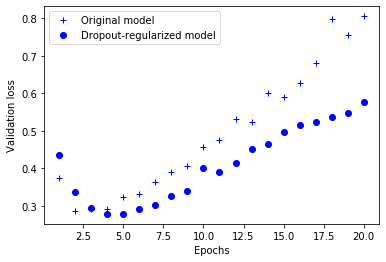

In [24]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

#### Batch Normalization
* Normalization (in general) aims to make different examples more similar to each other
    * Easier to learn and generalize
* Batch normalization layer adaptively normalizes data, even as the mean and variance change over time during training. 
    * It works by internally maintaining an exponential moving average of the batch-wise mean and variance of training data
    * Helps with gradient propagation, allows for deeper networks.
    
``` python
dense_model.add(layers.Dense(32, activation='relu')) 
dense_model.add(layers.BatchNormalization())
```

#### SGD Hyperparameter tuning
SGD has many important hyperparameters to tune:
* Learning rate
    * Too low: slow convergence, may get stuck in local minima
    * Too high: may lead to _divergence_: train loss _increases_ with training
* Learning rate decay
    * It is often useful to start with a high learning rate and then decrease it during training
    * Many variants of this approach exist
* Batch size
    * Small batch size may be slower, more erratic
    * Medium batch sizes (24-32) often recommended
    * Large batch sizes can decrease performance ('generalization gap')
    * [Intense research topic](https://openreview.net/pdf?id=B1Yy1BxCZ)
* ...

### Tuning multiple hyperparameters
* You can wrap Keras models as scikit-learn and use any of its tuning techniques
* Keras also has built-in RandomSearch (and HyperBand - see later)

```python
def build_model(hp){
    m.add(Dense(units=hp.Int(‘units’, min_value=32, max_value=512, step=32)))
    m.compile(optimizer=Adam(hp.Choice(‘learning rate’, [1e-2, 1e-3, 1e-4])))
    return model;}

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
clf = KerasClassifier(make_model)
grid = GridSearchCV(clf, param_grid=param_grid, cv=3)

from kerastuner.tuners import RandomSearch
tuner = keras.RandomSearch(build_model, max_trials=5)
```

In [25]:
# slow
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

def make_model(optimizer="adam", hidden_size=32):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

#clf = KerasClassifier(make_model)
#param_grid = {'epochs': [1, 5, 10],  # epochs is fit parameter, not in make_model!
#              'hidden_size': [32, 64, 256],
#              'verbose' : [0]}
#grid = GridSearchCV(clf, param_grid=param_grid, cv=3)
#grid.fit(x_train, y_train)

In [26]:
#model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, verbose=0)
#result = model.evaluate(x_test, one_hot_test_labels)
#print("Loss: {:.4f}, Accuracy: {:.4f}".format(*result))

### Regularization recap
* Get more training data
* Reduce the capacity of the network
* Try weight regularization, dropout, batch normalization
* Start with a simple model and add capacity, or start with a complex model and then regularize

## Handling textual data
Textual data can be represented in different ways
* Every 'document' (e.g. a review, tweet,...) is represented by a vector
* Bag-of-words representation
    * Build a dictionary of the most frequent words (e.g. 10000)
    * One-hot-encoding: 10000 features, '1.0' if the word occurs
    * TF-IDF: Term frequency over inverse document frequency
        * Count how many times each word occurs and normalize by the frequency across documents
* Word embeddings

#### Word Embeddings
* An embedding maps each word to a point in an n-dimensional space (e.g. 300 values), so that similar words are close to each other
    * Can usually be imported as an 'Embedding' layer. You need to either learn the embedding on your own dataset, or import a _pre-trained_ embedding (e.g. trained on Wikipedia).
* There are different ways to learn word embeddings. Most common are:
    * Word2Vec: Learn encoding based on the words that are typically in a window around the word
        * Encoding is learned using a 1-layer neural net
    * GloVe (Global Vector): Count co-occurrences of words in a matrix
        * Use a low-rank approximation to get a condensed vector representation
    * FastText: learns embedding for n-grams rather than complete words
        * Can also produce embeddings for new words
    * BERT, ELMO,...: learn a context-dependent embedding: the some word has a different embedding depending on the sentence it appears in

##### Word embeddings: Word2Vec and GloVe
<img src="../images/09_word_embeddings.png" alt="ml" style="width: 800px;"/>

##### Word2Vec
- Continuous bag of words (CBOW): train model to predict word given context, use weights of last layer as embedding
- Skip-Gram: train model to predict context given word, use weights of first layer as embedding (better for large corpora)

<img src="../images/09_word_embeddings_3.png" alt="ml" style="width: 600px;"/>

##### FastText
Like CBOW or SkipGram, but using n-grams instead of words
<img src="../images/09_word_embeddings_2.png" alt="ml" style="width: 800px;"/>

##### BERT, ELMO, GPT,...
* Uses _transformer (sequence-to-sequence) networks_ to learn contextual embeddings
    * `Encoder` network maps input sequence to high-dimensional representation, then a `Decoder` network maps it to the targer output sequence
    * Vaswani et al. (2017) [Attention is all you need](https://arxiv.org/abs/1706.03762)
* Devlin et al. (2018) BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding

<img src="../images/09_word_embeddings_4.png" alt="ml" style="width: 700px;"/>

### Summary

* Structure of (deep) neural networks
* Tensor operations
* Stochastic gradient descent
* Back-propagation
* Building neural nets
* Regularization: Weight regularization, Dropout, Batch normalization
* Handling textual data